In [1]:
import os

from pathlib import Path

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import arviz as az

from sphincter.plotting import save_figure

az.rcParams["data.load"] = "eager"

In [2]:
here = Path(os.path.realpath('.'))

root_dir = here.parent
collaterals_data_file = root_dir / "data" / "prepared" / "collaterals.csv"
mice_data_file = root_dir / "data" / "prepared" / "collaterals-mice.csv"
idata_dir = root_dir / "inferences" / "collaterals"

collaterals = pd.read_csv(collaterals_data_file)
mice = pd.read_csv(mice_data_file)
mice.head()

,Date,mouse_id,age,craniotomy_area,collaterals,collaterals_per_area,ln_collaterals_per_area
0,11020,11020,adult,6.312420,6,0.950507,-0.050760
1,40520,40520,adult,4.892264,5,1.022022,0.021783
2,41021,41021,old,7.024126,1,0.142366,-1.949351
3,50520,50520,old,6.257000,3,0.479463,-0.735089
4,51020,51020,adult,6.370858,6,0.941788,-0.059975


In [3]:
idata_ctls_per_area = az.from_netcdf(idata_dir / "ctls_per_area.nc")
az.summary(idata_ctls_per_area, var_names=["~sigma", "~mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.144,0.074,-0.290,-0.011,0.001,0.001,5107.0,2957.0,1.0
age[old],-0.464,0.202,-0.848,-0.086,0.004,0.003,3085.0,2326.0,1.0
sigma_Intercept,-0.934,0.135,-1.170,-0.664,0.002,0.002,3512.0,2256.0,1.0
sigma_age[old],0.564,0.230,0.132,1.004,0.004,0.003,3363.0,2626.0,1.0


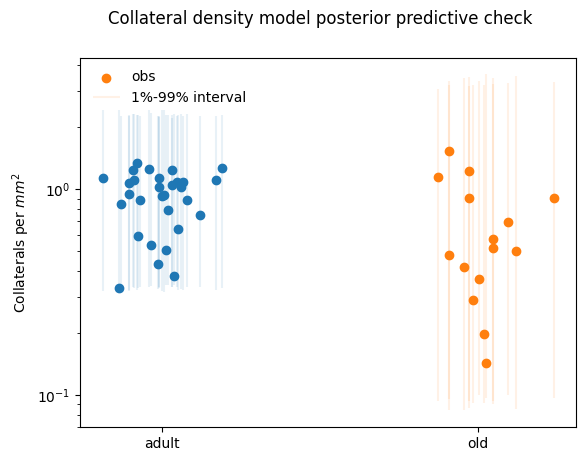

In [4]:
def plot_posterior_predictive(msts, idata, ycol, ax):

    qlow, qhigh = (
        np.exp(idata.posterior_predictive["ln_" + ycol].quantile(q, dim=["chain", "draw"]).to_numpy())
        for q in [0.01, 0.99]
    )
    x = msts["age"].map({"adult": 0, "old": 1}) + np.random.normal(scale=0.1,size=len(msts))
    plot_df = msts.join(x.rename("x"))
    plot_df["qlow"] = qlow
    plot_df["qhigh"] = qhigh
    
    for age, subdf in plot_df.groupby("age"):
        sct = ax.scatter(subdf["x"], subdf[ycol]);
        color = sct.get_edgecolors()[0]
        vl = ax.vlines(subdf["x"], subdf["qlow"], subdf["qhigh"], color=color, alpha=0.1)
    ax.set_xticks([0, 1], ["adult", "old"])
    ax.semilogy();
    ax.legend([sct, vl], ["obs", "1%-99% interval"], frameon=False, loc="upper left")
    return ax

f, ax = plt.subplots()
ax = plot_posterior_predictive(mice, idata_ctls_per_area, "collaterals_per_area", ax)
f.suptitle("Collateral density model posterior predictive check");
ax.set_ylabel("Collaterals per $mm^2$");
save_figure(f, "collaterals-ppc")


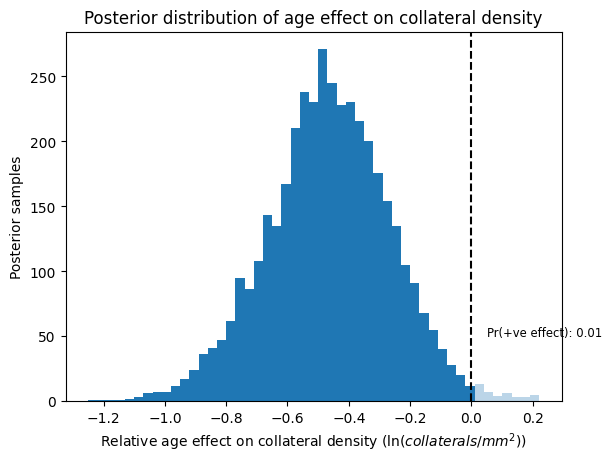

In [5]:

def plot_age_effect_samples(idata, ax):

    age_effect_samples = idata.posterior["age"].to_numpy().flatten()
    tstat = (age_effect_samples > 0).mean()
    bins = np.linspace(age_effect_samples.min(), age_effect_samples.max(), 50)
    
    ax.hist(age_effect_samples[age_effect_samples < 0], bins=bins);
    ax.hist(age_effect_samples[age_effect_samples > 0], bins=bins, alpha=0.3, color="tab:blue");
    
    
    ax.axvline(0.0, linestyle="--", color="black");
    ax.text(0.05, 50, f"Pr(+ve effect): {tstat.round(2)}", fontsize="small");
    return ax

f, ax = plt.subplots()
ax = plot_age_effect_samples(idata_ctls_per_area, ax)
ax.set(
    xlabel="Relative age effect on collateral density ($\\ln(collaterals/mm^2$))",
    ylabel="Posterior samples",
    title="Posterior distribution of age effect on collateral density"
);
save_figure(f, "collaterals-age-effect")

ln_diameter_mean:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.022,0.025,2.974,3.068,0.000,0.000,6546.0,3336.0,1.0
age[old],0.025,0.051,-0.065,0.121,0.001,0.001,5549.0,3071.0,1.0


ln_curved_length:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,6.087,0.042,6.006,6.164,0.001,0.000,6811.0,3052.0,1.0
age[old],0.080,0.084,-0.078,0.231,0.001,0.001,6712.0,2739.0,1.0


ln_m1_tortuosity:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.469,0.111,-2.670,-2.261,0.002,0.001,5198.0,3037.0,1.0
age[old],0.215,0.222,-0.218,0.612,0.003,0.003,5364.0,3253.0,1.0


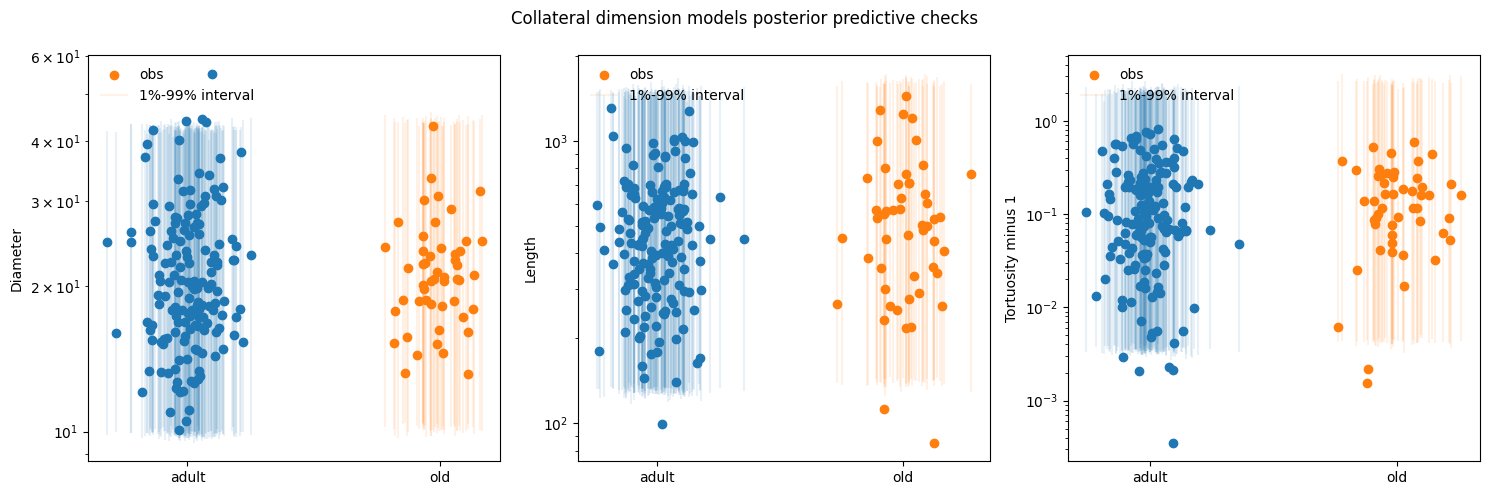

In [6]:
idatas_ctls = {
    ycol: az.from_netcdf(idata_dir / f"{ycol}.nc") 
    for ycol in ["ln_diameter_mean", "ln_curved_length", "ln_m1_tortuosity"]
}
ycol_to_title = {
    "ln_diameter_mean": "Diameter",
    "ln_curved_length": "Length",
    "ln_m1_tortuosity": "Tortuosity minus 1"
}

f, axes = plt.subplots(1, 3, figsize=[15, 5])
for (ycol, idata), ax in zip(idatas_ctls.items(), axes):
    print(ycol + ":")
    display(az.summary(idata, var_names=["~sigma", "~mu"]))
    ax = plot_posterior_predictive(collaterals, idata, ycol[3:], ax)
    ax.set(ylabel=ycol_to_title[ycol]);
f.suptitle("Collateral dimension models posterior predictive checks");
f.tight_layout()
save_figure(f, "collaterals-dimensions-ppc")

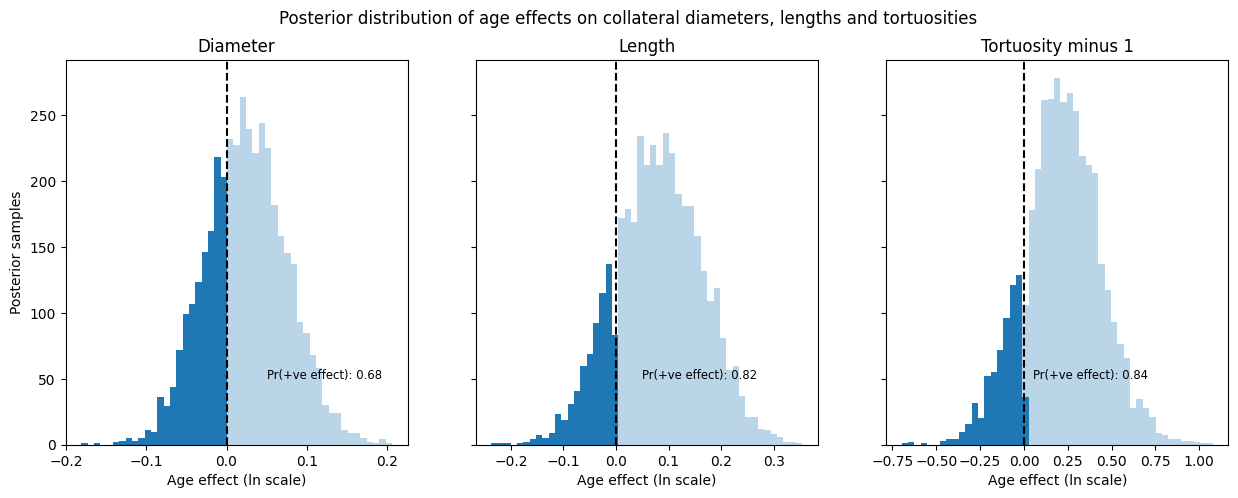

In [7]:
f, axes = plt.subplots(1, 3, figsize=[15, 5], sharey=True)

ycol_to_title = {
    "ln_diameter_mean": "Diameter",
    "ln_curved_length": "Length",
    "ln_m1_tortuosity": "Tortuosity minus 1"
}

for (ycol, idata), ax in zip(idatas_ctls.items(), axes):
    plot_age_effect_samples(idata, ax)
    ax.set(title=ycol_to_title[ycol], xlabel="Age effect (ln scale)");
axes[0].set_ylabel("Posterior samples")
f.suptitle("Posterior distribution of age effects on collateral diameters, lengths and tortuosities");
save_figure(f, "collaterals-age-non-effects")